In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score
)

from utils import get_data, calc_reconstruction_error

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [4]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Apply PCA with 3 components and KMeans

In [12]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 3
N_JOBS = -1

scaler = StandardScaler()
dim_redn = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
clus = KMeans(n_jobs=N_JOBS, n_init=100)

clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn),
    ('model', clus)
])


In [13]:
results = {}
for n_clusters in range(2, 20):
    print(f"---------- n_clusters: {n_clusters} ----------")
    clus_pipeline.set_params(model__n_clusters=n_clusters)
    clus_pipeline.fit(X_train)
    
    clus_labels = clus_pipeline.named_steps['model'].labels_
    sil_score = silhouette_score(X_train, clus_labels)
    
    results[n_clusters] = {'inertia': clus_pipeline.named_steps['model'].inertia_,
                           'sil_score': sil_score}

---------- n_clusters: 2 ----------
---------- n_clusters: 3 ----------
---------- n_clusters: 4 ----------
---------- n_clusters: 5 ----------
---------- n_clusters: 6 ----------
---------- n_clusters: 7 ----------
---------- n_clusters: 8 ----------
---------- n_clusters: 9 ----------
---------- n_clusters: 10 ----------
---------- n_clusters: 11 ----------
---------- n_clusters: 12 ----------
---------- n_clusters: 13 ----------
---------- n_clusters: 14 ----------
---------- n_clusters: 15 ----------
---------- n_clusters: 16 ----------
---------- n_clusters: 17 ----------
---------- n_clusters: 18 ----------
---------- n_clusters: 19 ----------


# Apply ICA

In [13]:
RANDOM_STATE = 42

scaler = StandardScaler()
dim_redn = FastICA(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])


In [14]:
results = []
ica_recon_err = {}
for n_components in range(1, X_train.shape[1]+1):
    print(f"---------- n_components: {n_components} ----------")
    dr_pipeline.set_params(dim_redn__n_components=n_components)

    X_transformed = dr_pipeline.fit_transform(X_train)
    
    res = stats.kurtosistest(X_transformed)
    res.statistic, res.pvalue
    
    results.append(pd.DataFrame({'n_components': [n_components]*n_components,
                            'component': np.arange(1, n_components+1),
                             'kurtosis_stat': res.statistic,
                             'kurtosis_pvalue': res.pvalue}
                           ))
    
    X_reconstructed = dr_pipeline.inverse_transform(X_transformed)
    reconstruction_error = calc_reconstruction_error(X_train, X_reconstructed)

    print(f'ICA with {n_components} components has a reconstruction error of {reconstruction_error:.2f}')
    ica_recon_err[n_components] = reconstruction_error


---------- n_components: 1 ----------
ICA with 1 components has a reconstruction error of 508350511.52
---------- n_components: 2 ----------
ICA with 2 components has a reconstruction error of 61381024.76
---------- n_components: 3 ----------
ICA with 3 components has a reconstruction error of 54236109.70
---------- n_components: 4 ----------
ICA with 4 components has a reconstruction error of 52955443.73
---------- n_components: 5 ----------
ICA with 5 components has a reconstruction error of 46630691.00
---------- n_components: 6 ----------
ICA with 6 components has a reconstruction error of 3742379.24
---------- n_components: 7 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA with 7 components has a reconstruction error of 854032.58
---------- n_components: 8 ----------
ICA with 8 components has a reconstruction error of 463614.75
---------- n_components: 9 ----------
ICA with 9 components has a reconstruction error of 446701.53
---------- n_components: 10 ----------
ICA with 10 components has a reconstruction error of 78105.14
---------- n_components: 11 ----------
ICA with 11 components has a reconstruction error of 11244.42
---------- n_components: 12 ----------
ICA with 12 components has a reconstruction error of 9064.94
---------- n_components: 13 ----------
ICA with 13 components has a reconstruction error of 7314.45
---------- n_components: 14 ----------
ICA with 14 components has a reconstruction error of 249.25
---------- n_components: 15 ----------
ICA with 15 components has a reconstruction error of 176.67
---------- n_components: 16 ----------
ICA with 16 components has a reconstruction error of 0.00


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [15]:
results_df  = pd.concat(results)

<Axes: xlabel='component', ylabel='kurtosis_stat'>

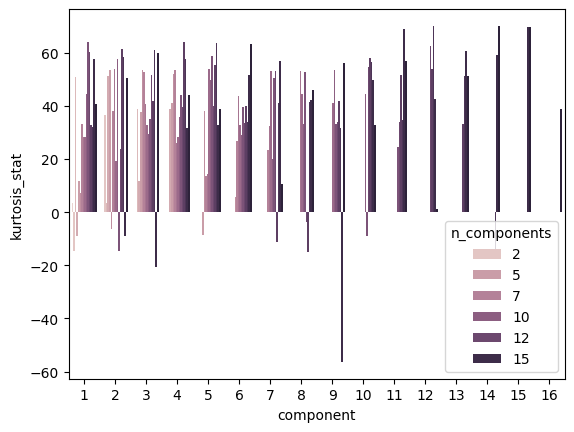

In [16]:
sns.barplot(x='component', y='kurtosis_stat', data=results_df, hue='n_components')

<Axes: xlabel='n_components', ylabel='kurtosis_stat'>

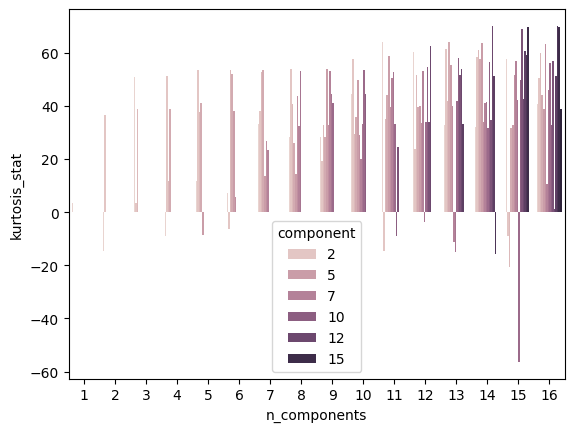

In [17]:
sns.barplot(x='n_components', y='kurtosis_stat', data=results_df, hue='component')

<Axes: xlabel='component', ylabel='kurtosis_pvalue'>

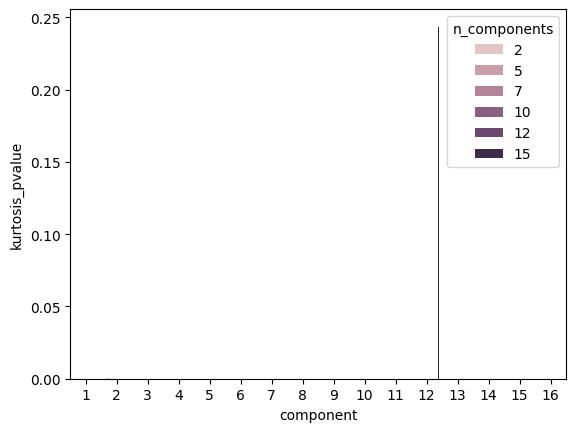

In [18]:
sns.barplot(x='component', y='kurtosis_pvalue', data=results_df, hue='n_components')

<Axes: xlabel='component', ylabel='kurtosis_pvalue'>

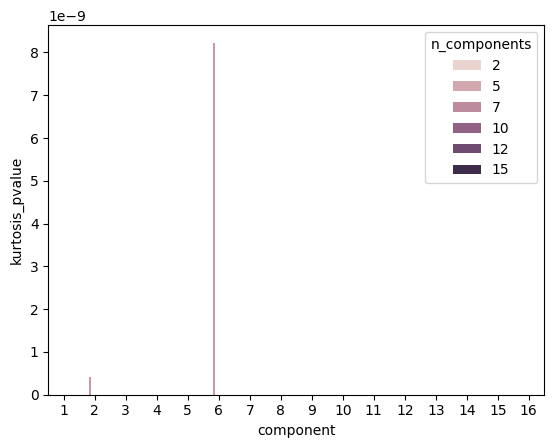

In [19]:
sns.barplot(x='component', y='kurtosis_pvalue', data=results_df.query('kurtosis_pvalue < 0.0001'), hue='n_components')

<Axes: title={'center': 'Reconstruction Error by Number of Components'}, xlabel='n_components'>

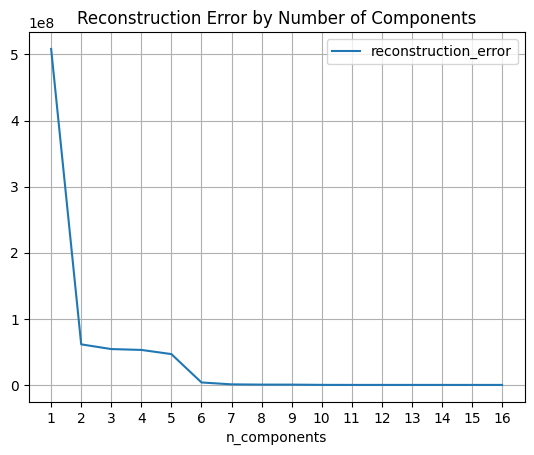

In [20]:
ica_recon_err_df = pd.DataFrame(ica_recon_err.items(), columns=['n_components', 'reconstruction_error'])
ica_recon_err_df.plot(x='n_components', y='reconstruction_error', title='Reconstruction Error by Number of Components', xticks=ica_recon_err_df['n_components'], grid=True)

# Apply Gaussian projection

In [22]:
RANDOM_STATE = 42

scaler = StandardScaler()
dim_redn = GaussianRandomProjection(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])

In [24]:
# reconstruction error
rand_proj_recon_err = {}
for n_components in range(1, X_train.shape[1]+1):
    print(f"---------- n_components: {n_components} ----------")
    dr_pipeline.set_params(dim_redn__n_components=n_components)

    X_transformed = dr_pipeline.fit_transform(X_train)
    X_reconstructed = dr_pipeline.inverse_transform(X_transformed)
    reconstruction_error = calc_reconstruction_error(X_train, X_reconstructed)

    print(f'GaussRandProj with {n_components} components has a reconstruction error of {reconstruction_error:.2f}')
    rand_proj_recon_err[n_components] = reconstruction_error


---------- n_components: 1 ----------
GaussRandProj with 1 components has a reconstruction error of 744810429.91
---------- n_components: 2 ----------
GaussRandProj with 2 components has a reconstruction error of 702492661.25
---------- n_components: 3 ----------
GaussRandProj with 3 components has a reconstruction error of 838747407.18
---------- n_components: 4 ----------
GaussRandProj with 4 components has a reconstruction error of 915359779.79
---------- n_components: 5 ----------
GaussRandProj with 5 components has a reconstruction error of 889853452.43
---------- n_components: 6 ----------
GaussRandProj with 6 components has a reconstruction error of 838521555.24
---------- n_components: 7 ----------
GaussRandProj with 7 components has a reconstruction error of 1109070363.38
---------- n_components: 8 ----------
GaussRandProj with 8 components has a reconstruction error of 1224244496.35
---------- n_components: 9 ----------
GaussRandProj with 9 components has a reconstruction err

<Axes: title={'center': 'Reconstruction Error by Number of Components'}, xlabel='n_components'>

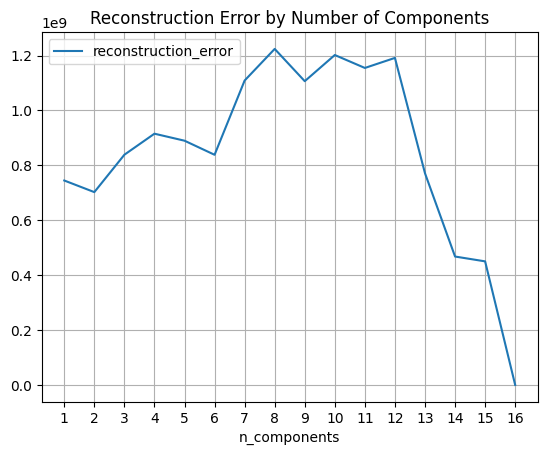

In [26]:
rand_proj_recon_err = pd.DataFrame(rand_proj_recon_err.items(), columns=['n_components', 'reconstruction_error'])
rand_proj_recon_err.plot(x='n_components', y='reconstruction_error', title='Reconstruction Error by Number of Components', xticks=rand_proj_recon_err['n_components'], grid=True)

# Apply t-SNE

In [29]:
RANDOM_STATE = 42

scaler = StandardScaler()
dim_redn = TSNE(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])

In [33]:

tsne_kl_divergence = {}
for n_components in range(1, 4):
    print(f"---------- n_components: {n_components} ----------")
    dr_pipeline.set_params(dim_redn__n_components=n_components)

    dr_pipeline.fit(X_train)
    
    kl_divergence = dr_pipeline.named_steps['dim_redn'].kl_divergence_

    print(f'TSNE with {n_components} components has a kl_divergence of {kl_divergence:.2f}')
    tsne_kl_divergence[n_components] = kl_divergence

---------- n_components: 1 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE with 1 components has a kl_divergence of 2.55
---------- n_components: 2 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE with 2 components has a kl_divergence of 1.80
---------- n_components: 3 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE with 3 components has a kl_divergence of 1.44
